In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from IPython.display import Markdown, display
import pandas as pd

import os
print(os.listdir("./input"))

['historical_transactions.csv', '.ipynb_checkpoints', 'new_merchant_transactions.csv', 'merchants.csv', 'sample_submission.csv', 'test.csv', 'Data_Dictionary.xlsx', '.gitignore', 'train.csv']


In [ ]:
train_df = pd.read_csv('./input/train.csv', sep=',', parse_dates=["first_active_month"])
# Don't really need this file (no target column)
# test_df = pd.read_csv('./input/test.csv', sep=',', parse_dates=["first_active_month"]))

In [4]:
print(train_df.target.describe())

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64


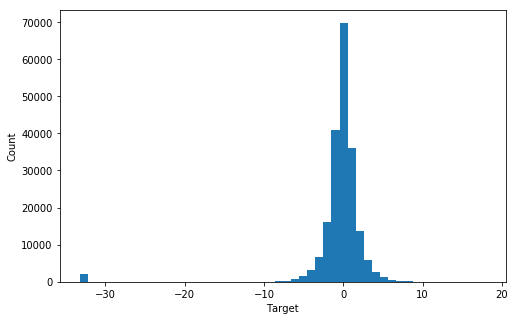

In [5]:
plt.figure(figsize=(8, 5))
plt.hist(train_df.target.values, bins=50)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

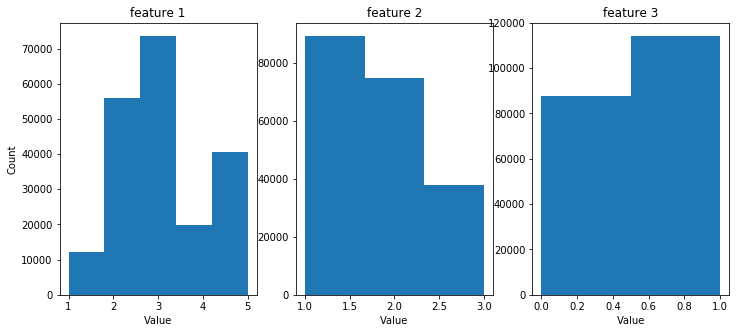

In [15]:

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12.0, 5.0))

ax1.hist(train_df.feature_1.values, bins=5)
ax1.set_title('feature 1')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

ax2.hist(train_df.feature_2.values, bins=3)
ax2.set_title('feature 2')
ax2.set_xlabel('Value')
# ax2.set_ylabel('Count')

ax3.hist(train_df.feature_3.values, bins=2)
ax3.set_title('feature 3')
ax3.set_xlabel('Value')
# ax3.set_ylabel('Count')


fig1.show()

In [2]:

# Grab only the features since ndarrays need to be homogeneous
training_df = train_df[['feature_1', 'feature_2', 'feature_3']]
labels_df = train_df[['target']]

# Split data in to train and test (80/20)
data_len = len(training_df)
train_data = training_df.values[:int(data_len*.8)]
train_labels = labels_df.values.flatten()[:int(data_len*.8)]
test_data = training_df.values[int(data_len*.8):]
test_labels = labels_df.values.flatten()[int(data_len*.8):]

In [3]:
print(data_len)
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(train_data.shape[0] + test_data.shape[0])

print()

201917
(161533, 3)
(161533,)
(40384, 3)
(40384,)
201917
